## Ventilator 데이터를 이용한 환자 exhale pressure 예측하기

Source : https://www.kaggle.com/competitions/ventilator-pressure-prediction

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. 라이브러리 불러오기

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter

warnings.filterwarnings("ignore")
small = True # 작은 데이터셋으로 학습을 테스트하는 용도입니다.

### 2. 데이터 불러오기

In [6]:
base_path = "/content/drive/MyDrive/Colab Notebooks/data/ventilator-pressure-prediction/"

train = pd.read_csv(base_path + 'train.csv')
test = pd.read_csv(base_path + 'test.csv')

print(train.shape, test.shape)

(6036000, 8) (4024000, 7)


In [7]:
train

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938


In [9]:
# 실습을 위해 데이터 1% 정도로 샘플링합니다.
if small:
  train = train[train['breath_id'] < 1000].reset_index(drop=True)
  display(train)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
50795,50796,999,50,50,2.386138,4.941322,1,6.610815
50796,50797,999,50,50,2.417893,4.949937,1,6.962326
50797,50798,999,50,50,2.449599,4.957276,1,7.102930
50798,50799,999,50,50,2.481339,4.963546,1,6.540513


### 3. EDA

In [10]:
def plot_sample(sample_id, df):
    df_breath = df[df['breath_id'] == sample_id]
    r, c  = df_breath[['R', 'C']].values[0]

    cols = ['u_in', 'u_out', 'pressure'] if 'pressure' in df.columns else ['u_in', 'u_out']
    
    plt.figure(figsize=(12, 4))
    for col in ['u_in', 'u_out', 'pressure']:
        plt.plot(df_breath['time_step'], df_breath[col], label=col)
        
    plt.legend()
    plt.title(f'breath_id: {sample_id} - R={r}, C={c}')

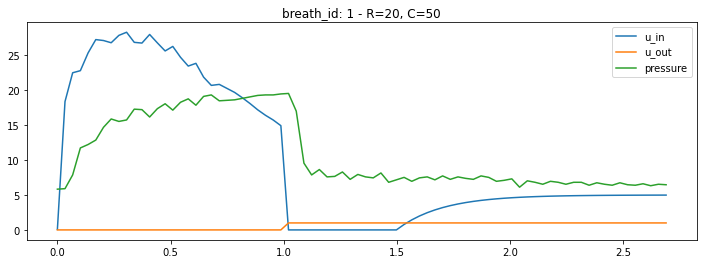

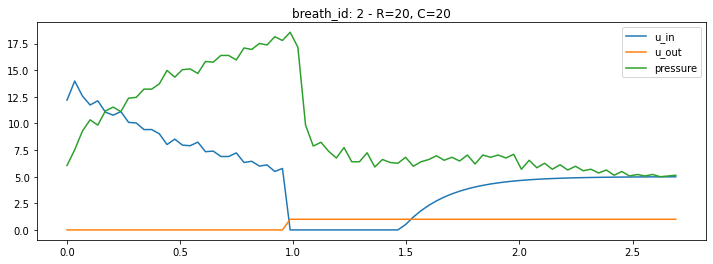

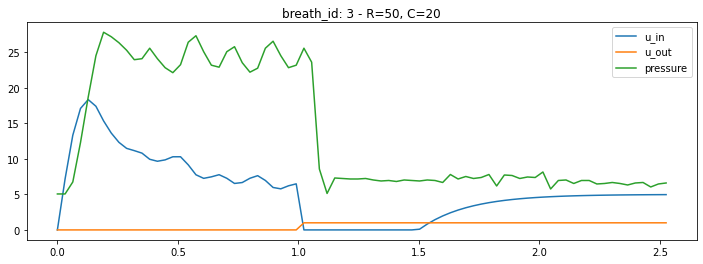

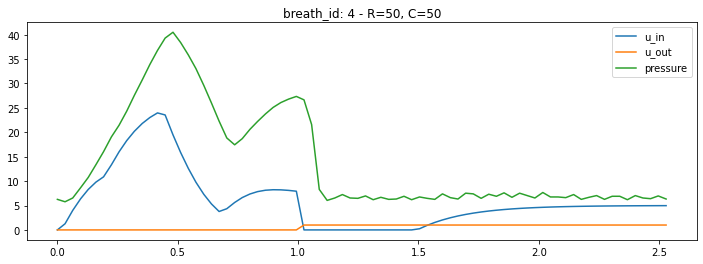

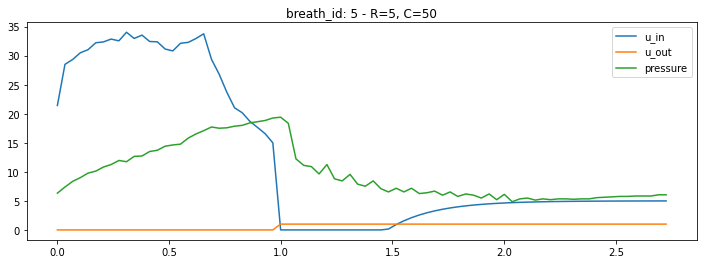

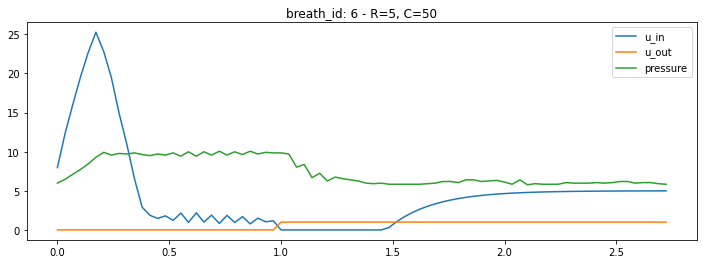

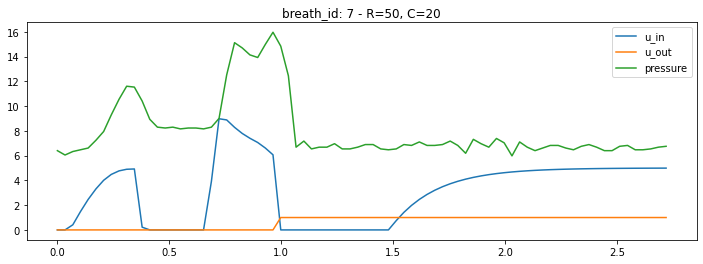

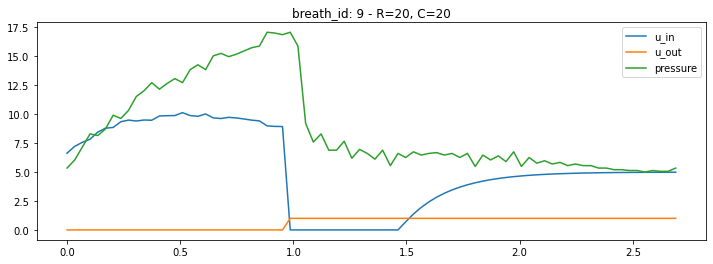

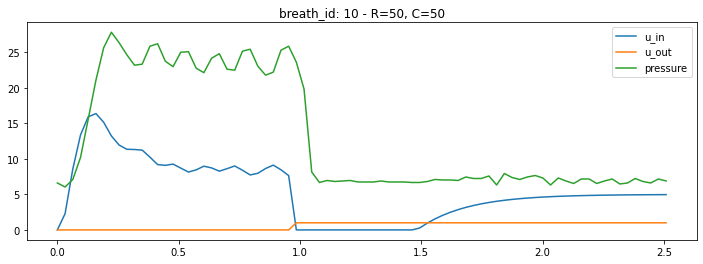

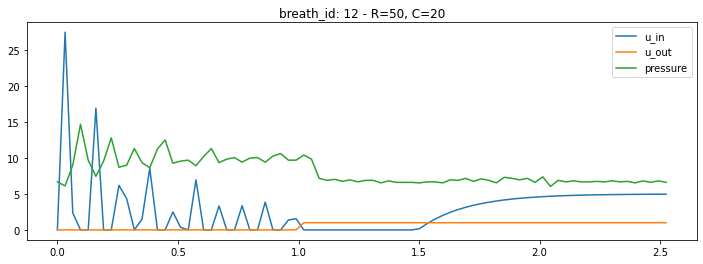

In [11]:
for i in train['breath_id'].unique()[:10]: # 10명만 출력.
    plot_sample(i, train)

### 4. Sequential Modeling

- Data preparation

In [12]:
seq_len = 80

y_train = train.pressure.to_numpy().reshape(-1, seq_len)
X_train = train.drop(columns=["pressure", "id", "breath_id"])
test = test.drop(columns=["id", "breath_id"])

In [13]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
test = scaler.transform(test)

# reshaping
X_train = X_train.reshape(-1, seq_len, X_train.shape[-1])
test = test.reshape(-1, seq_len, test.shape[-1])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(508, 80, 5) (127, 80, 5) (508, 80) (127, 80)


In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense

#### Model

- 4 Layers Bi-LSTM + FC layer
- Adam Optimizer
- ReduceLRonPlateau scheduler

In [15]:
# config variables
epochs = 200
batch_size = 1024
if small:
  epochs = 100
  batch_size = 128


scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

model = Sequential([
                    Input(shape=X_train.shape[1:]),
                    Bidirectional(LSTM(250, return_sequences=True)),
                    Bidirectional(LSTM(200, return_sequences=True)),
                    Bidirectional(LSTM(150, return_sequences=True)),
                    Bidirectional(LSTM(100, return_sequences=True)),
                    Dense(50, activation='relu'),
                    Dense(1) # output layer
])

model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 80, 500)          512000    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 80, 400)          1121600   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 80, 300)          661200    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 80, 200)          320800    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 80, 50)            1

#### Training

In [16]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[scheduler],
                    verbose=1)

Epoch 1/100
4/4 [==============================] - 21s 1s/step - loss: 10.2719 - val_loss: 7.2008 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 1s 305ms/step - loss: 5.6772 - val_loss: 5.5020 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 1s 290ms/step - loss: 5.2995 - val_loss: 5.3144 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 1s 289ms/step - loss: 5.0501 - val_loss: 5.1489 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 1s 290ms/step - loss: 4.8815 - val_loss: 4.8984 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 1s 291ms/step - loss: 4.5862 - val_loss: 4.4609 - lr: 0.0010
Epoch 7/100
4/4 [==============================] - 1s 293ms/step - loss: 4.1336 - val_loss: 4.0062 - lr: 0.0010
Epoch 8/100
4/4 [==============================] - 1s 288ms/step - loss: 4.0578 - val_loss: 4.1052 - lr: 0.0010
Epoch 9/100
4/4 [==============================] - 1s 288ms/step - loss: 3.8201 - val_loss: 3.7491 - lr: 

### 5. Prediction

In [17]:
preds = model.predict(test).squeeze().reshape(-1, 1).squeeze()
preds

array([6.297862 , 6.4243426, 7.5497255, ..., 6.2998457, 6.3142524,
       6.2683372], dtype=float32)

In [19]:
len(preds)

4024000

In [18]:
submission = pd.read_csv(base_path + "sample_submission.csv")
submission

,id,pressure
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
4023995,4023996,0
4023996,4023997,0
4023997,4023998,0
4023998,4023999,0


In [21]:
submission['pressure'] = preds
output_path = "submission_full.csv"
if small:
  output_path = "submission_small.csv"
submission.to_csv(base_path + output_path, index=False)

**한번 제출해보세요!**

Link : https://www.kaggle.com/competitions/ventilator-pressure-prediction/leaderboard